In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import random
import matplotlib.pyplot as plt  
from scipy.stats import norm  
import keras
from keras.models import Sequential
from keras.initializers import VarianceScaling,RandomNormal
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D
from keras.layers import UpSampling2D, Reshape, Lambda, Flatten, Activation
from keras.models import Model  
from keras.optimizers import SGD, Adadelta, Adagrad,Adam
from keras import backend as K  
from keras import objectives  
from keras.utils.vis_utils import plot_model  
from keras.utils import np_utils, generic_utils
import sys 
import tensorflow as tf
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
import matplotlib.pyplot as plt
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import sklearn
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from sklearn import manifold, datasets
from sklearn.utils import check_random_state
from sklearn import metrics

Using TensorFlow backend.


In [2]:
path = os.listdir('cstor/xsede/users/xs-haosun/SDSS_2000/')
#pick up the 1st image to have a look   
path_now = path[0]
a = np.load('cstor/xsede/users/xs-haosun/SDSS_2000/'+str(path_now))
Obj_ID = []
Image = []
Class = []
Redshift = []
for i in range(len(path)):
    path_now = path[i]
    a = np.load('cstor/xsede/users/xs-haosun/SDSS_2000/'+str(path_now))
    for j in range(a.shape[0]):
        Obj_ID.append(a[j]['objID'])
        Image.append(a[j]['image'])
        Class.append(a[j]['class'])
        Redshift.append(a[j]['z'])
Obj_ID = np.asarray(Obj_ID)
Image = np.asarray(Image)
Class = np.asarray(Class)
Redshift = np.asarray(Redshift)
Class[Class=='STAR'] = 0
Class[Class=='GALAXY'] = 1
Class[Class=='QSO'] = 2
Class = Class.astype(int)

Image_RGB = np.empty((len(Image),64,64,3))#(14142,64,64,3) RGB images
for i in range(len(Image)):
    #b[i] = np.stack((a[i][1][0],a[i][1][1],a[i][1][2],a[i][1][3],a[i][1][4]),axis=-1)
    Image_RGB[i] = np.stack((Image[i][3],Image[i][2],Image[i][1]),axis=-1)


for i in range(len(Image_RGB)):
    if True in np.isnan(Image_RGB[i]).reshape(64*64*3):
        print(i)
        Image_RGB[i][np.isnan(Image_RGB[i])==True]=np.mean(Image_RGB[i-1])
        
Image_RGB -= np.mean(Image_RGB)
Image_RGB /= np.max(Image_RGB)

815


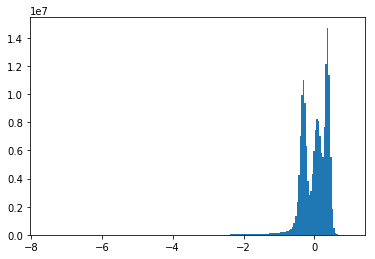

In [3]:
plt.hist(Image_RGB.reshape(-1,),200)
plt.show()

In [4]:
label = np_utils.to_categorical(Class, 3)
data = Image_RGB
index = [i for i in range(len(data))]
#random.shuffle(index)
train_data = data[index]
train_label = label[index]
Class = Class[index]
Redshift = Redshift[index]
print('train_data.shape:',train_data.shape)
print('train_label.shape:',train_label.shape)

train_data.shape: (14142, 64, 64, 3)
train_label.shape: (14142, 3)


# Traditional VAE

In [9]:
batch_size =100
latent_dim = 2
nb_epoch = 50  
epsilon_std = 0.1 
intermediate_dim =256
original_dim = 64*64

#USE = 'autoencoder'
USE = 'vae'
#encoder:

input_img = Input(shape=(64,64,3))


x = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(input_img)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

#x = Conv2D(5, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
#x = MaxPooling2D((2, 2),  padding='same')(x)

visual = Flatten()(x)
h_1 = Dense(intermediate_dim, activation='tanh')(visual)
encoded = Dense(latent_dim, activation='relu')(h_1)

z_mean = Dense(latent_dim)(h_1)
z_log_var = Dense(latent_dim)(h_1)

def sampling(args):   
    z_mean, z_log_var = args  
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2)* epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

if USE == 'vae':
    h_3 = Dense(intermediate_dim,activation='tanh')(z)#for VAE

if USE == 'autoencoder':
    h_3 = Dense(intermediate_dim,activation='tanh')(encoded)#for AE
    
    
h_4 = Dense(20*2*2,activation='relu')(h_3)
h_5 = Reshape((2,2,20))(h_4)


x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(h_5)
x = UpSampling2D((2, 2))(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(80,  (3, 3), activation='tanh',padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(3, (3, 3), activation='tanh', padding='same')(x)

EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')


def vae_loss(x, decoded):
    xent_loss = K.sum(K.sum(objectives.binary_crossentropy(x ,decoded),axis=-1),axis=-1)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) 
    return xent_loss + 1*kl_loss  

def ae_loss(x, decoded):  
    xent_loss = original_dim * objectives.mean_squared_error(x,decoded)
    return xent_loss

if USE == 'autoencoder':
    autoencoder = Model(inputs=input_img, outputs=decoded)
    autoencoder.compile(optimizer='rmsprop', loss=ae_loss)
if USE == 'vae':
    vae = Model(inputs=input_img, outputs=decoded) 
    vae.compile(optimizer='rmsprop', loss=vae_loss) 

In [12]:
vae.fit(train_data[:12000], train_data[:12000],
        shuffle=True,
        epochs=50,
        batch_size=batch_size,
        validation_data=(train_data[12000:14100],train_data[12000:14100]),callbacks=[EarlyStopping])

Train on 12000 samples, validate on 2100 samples
Epoch 1/50
12000/12000 [==============================] - 18s - loss: -7658.4517 - val_loss: -7919.2448
Epoch 2/50
12000/12000 [==============================] - 18s - loss: -7845.4687 - val_loss: -7948.3654
Epoch 3/50
12000/12000 [==============================] - 18s - loss: -7978.2093 - val_loss: -7870.9753
Epoch 4/50
12000/12000 [==============================] - 18s - loss: -7990.3976 - val_loss: -7926.6641
Epoch 5/50
12000/12000 [==============================] - 18s - loss: -8021.8721 - val_loss: -8008.0491
Epoch 6/50
12000/12000 [==============================] - 18s - loss: -8000.7724 - val_loss: -8010.8018
Epoch 7/50
12000/12000 [==============================] - 18s - loss: -8025.5131 - val_loss: -7844.3523
Epoch 8/50
12000/12000 [==============================] - 18s - loss: -8045.0522 - val_loss: -8013.4722
Epoch 9/50
12000/12000 [==============================] - 18s - loss: -8028.3756 - val_loss: -7982.5809
Epoch 10/50
120

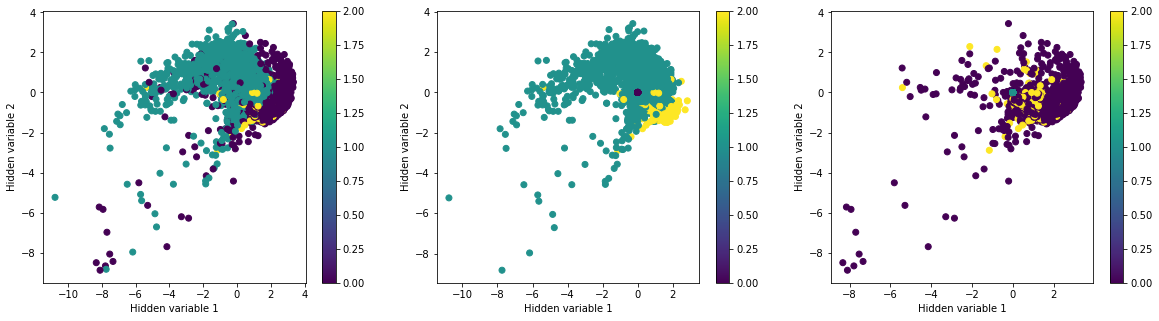

In [13]:
lower_lim = 0
upper_lim = 14100

label_value = np.zeros(len(train_label))
for i in range(len(label_value)):
    label_value[i] =np.argmax(train_label[i])

vis = Model(input_img, z_mean)

# display a 2D plot of the digit classes in the latent space  
x_vis = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)

x_vis_1 = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)  
x_vis_1[label_value[lower_lim:upper_lim]<1]=0

x_vis_2 = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)  
x_vis_2[label_value[lower_lim:upper_lim]==1]=0

plt.figure(figsize=(20, 5))

ax = plt.subplot(1,3,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,3,2)
plt.scatter( x_vis_1[:, 0] ,x_vis_1[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,3,3)
plt.scatter( x_vis_2[:, 0] ,x_vis_2[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()

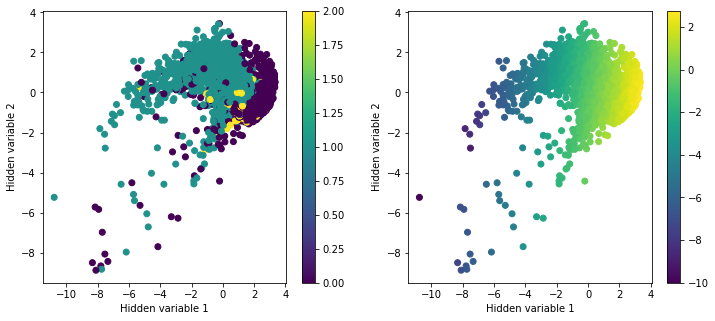

In [14]:
lower_lim = 0
upper_lim = 14100


vis = Model(input_img, z_mean)
# display a 2D plot of the digit classes in the latent space
x_vis = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)
n_neighbors = 10
n_components = 1
isomap = manifold.Isomap(n_neighbors, n_components)
hid_pred = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)
Y_pred = isomap.fit_transform(hid_pred)


plt.figure(figsize=(12, 5))

ax = plt.subplot(1,2,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,2,2)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=Y_pred)
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()

10000
AUC: 0.830291992488


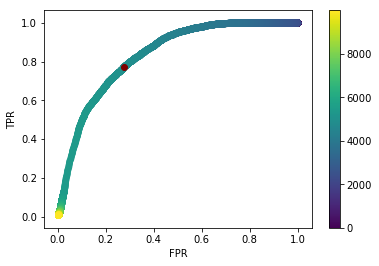

In [15]:
Y_pred = -Y_pred
thr_min = -5
thr_max = 5
test_accuracy = 0.001
test_range = int((thr_max - thr_min)/test_accuracy)
print(test_range)
FP = []
TP = []
TN = []
FN = []
TA = np.ones((Y_pred.shape[0],))
TA[Class[lower_lim:upper_lim] ==0 ] = 0
TA[Class[lower_lim:upper_lim] ==2 ] = 0

for i in range(test_range):
    FP_temp = np.zeros((Y_pred.shape[0]))
    TP_temp = np.zeros((Y_pred.shape[0]))
    TN_temp = np.zeros((Y_pred.shape[0]))
    FN_temp = np.zeros((Y_pred.shape[0]))
    LA = np.zeros((Y_pred.shape[0],))
    thr_now = thr_min+ i*test_accuracy
    LA[Y_pred[:,0] > thr_now] = 1
    for j in range(Y_pred.shape[0]):
        if LA[j]==0:
            if TA[j]==1:
                FN_temp[j] = 1
            else:
                TN_temp[j] = 1
        else:
            if TA[j] == 1:
                TP_temp[j] = 1
            else:
                FP_temp[j] = 1
    FP.append(FP_temp)
    TP.append(TP_temp)
    TN.append(TN_temp)
    FN.append(FN_temp)
    
TPR = np.zeros((test_range,))
FPR = np.zeros((test_range,))
TPR = np.sum(TP,axis=-1)/(np.sum(TP,axis=-1)+np.sum(FN,axis=-1))
FPR = np.sum(FP,axis=-1)/(np.sum(FP,axis=-1)+np.sum(TN,axis=-1))

plt.scatter(FPR,TPR,c=[i for i in range(test_range)])

plt.colorbar()
plt.scatter(FPR[np.argmin((TPR-1)**2 + FPR**2)],TPR[np.argmin((TPR-1)**2 + FPR**2)],c=0,cmap='OrRd_r')
plt.xlabel('FPR')
plt.ylabel('TPR')
#argmax, OrRed

print("AUC:",metrics.auc(FPR, TPR))

# KL-scaling

In [16]:
batch_size =100
latent_dim = 2
nb_epoch = 50  
epsilon_std = 0.1 
intermediate_dim =256
original_dim = 64*64

#USE = 'autoencoder'
USE = 'vae'
#encoder:

input_img = Input(shape=(64,64,3))


x = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(input_img)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

#x = Conv2D(5, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
#x = MaxPooling2D((2, 2),  padding='same')(x)

visual = Flatten()(x)
h_1 = Dense(intermediate_dim, activation='tanh')(visual)
encoded = Dense(latent_dim, activation='relu')(h_1)

z_mean = Dense(latent_dim)(h_1)
z_log_var = Dense(latent_dim)(h_1)

def sampling(args):   
    z_mean, z_log_var = args  
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2)* epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

if USE == 'vae':
    h_3 = Dense(intermediate_dim,activation='tanh')(z)#for VAE

if USE == 'autoencoder':
    h_3 = Dense(intermediate_dim,activation='tanh')(encoded)#for AE
    
    
h_4 = Dense(20*2*2,activation='relu')(h_3)
h_5 = Reshape((2,2,20))(h_4)


x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(h_5)
x = UpSampling2D((2, 2))(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(80,  (3, 3), activation='tanh',padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(3, (3, 3), activation='tanh', padding='same')(x)

EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')


def vae_loss(x, decoded):
    xent_loss = K.sum(K.sum(objectives.binary_crossentropy(x ,decoded),axis=-1),axis=-1)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - 0.5*K.square(z_mean-1) - 0.5*K.square(z_mean+1) - K.exp(z_log_var), axis=-1) 
    return xent_loss + 1*kl_loss  

def ae_loss(x, decoded):  
    xent_loss = original_dim * objectives.mean_squared_error(x,decoded)
    return xent_loss

if USE == 'autoencoder':
    autoencoder = Model(inputs=input_img, outputs=decoded)
    autoencoder.compile(optimizer='rmsprop', loss=ae_loss)
if USE == 'vae':
    vae = Model(inputs=input_img, outputs=decoded) 
    vae.compile(optimizer='rmsprop', loss=vae_loss) 

In [17]:
vae.fit(train_data[:12000], train_data[:12000],
        shuffle=True,
        epochs=50,
        batch_size=batch_size,
        validation_data=(train_data[12000:14100],train_data[12000:14100]),callbacks=[EarlyStopping])

Train on 12000 samples, validate on 2100 samples
Epoch 1/50
12000/12000 [==============================] - 19s - loss: -7256.9308 - val_loss: -7656.8647
Epoch 2/50
12000/12000 [==============================] - 18s - loss: -7756.6234 - val_loss: -7986.3044
Epoch 3/50
12000/12000 [==============================] - 18s - loss: -7918.8351 - val_loss: -8002.6329
Epoch 4/50
12000/12000 [==============================] - 18s - loss: -7982.1561 - val_loss: -7973.0057
Epoch 5/50
12000/12000 [==============================] - 18s - loss: -7998.9477 - val_loss: -7996.4201
Epoch 6/50
12000/12000 [==============================] - 18s - loss: -8006.2420 - val_loss: -7956.9635
Epoch 7/50
12000/12000 [==============================] - 18s - loss: -8021.9686 - val_loss: -8007.7720
Epoch 8/50
12000/12000 [==============================] - 18s - loss: -8025.0940 - val_loss: -8002.5832
Epoch 9/50
12000/12000 [==============================] - 18s - loss: -8034.9979 - val_loss: -8001.1396
Epoch 10/50
120

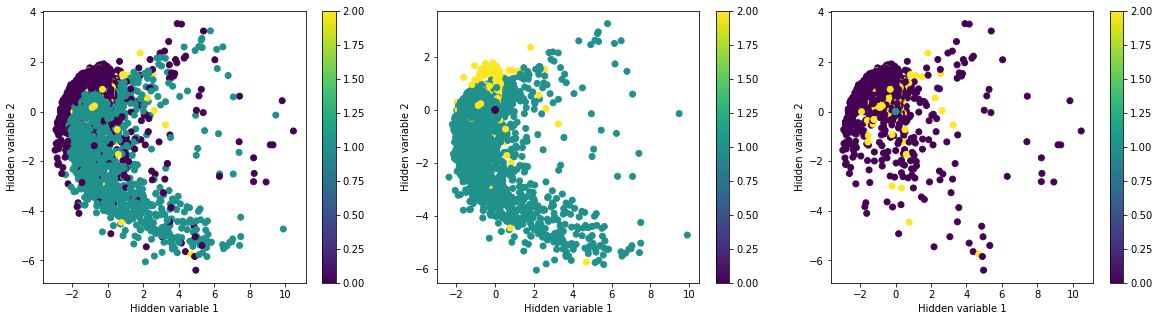

In [18]:
lower_lim = 0
upper_lim = 14100

label_value = np.zeros(len(train_label))
for i in range(len(label_value)):
    label_value[i] =np.argmax(train_label[i])

vis = Model(input_img, z_mean)

# display a 2D plot of the digit classes in the latent space  
x_vis = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)

x_vis_1 = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)  
x_vis_1[label_value[lower_lim:upper_lim]<1]=0

x_vis_2 = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)  
x_vis_2[label_value[lower_lim:upper_lim]==1]=0

plt.figure(figsize=(20, 5))

ax = plt.subplot(1,3,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,3,2)
plt.scatter( x_vis_1[:, 0] ,x_vis_1[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,3,3)
plt.scatter( x_vis_2[:, 0] ,x_vis_2[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()

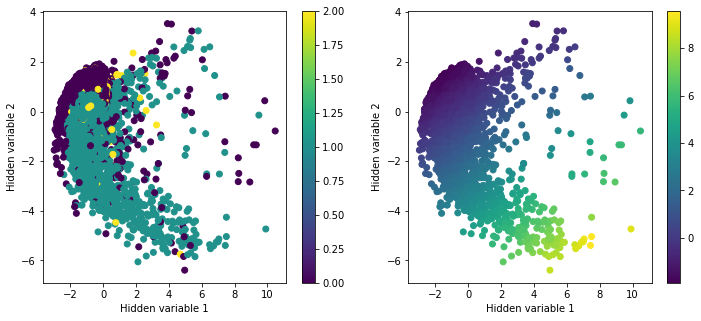

In [19]:
lower_lim = 0
upper_lim = 14100


vis = Model(input_img, z_mean)
# display a 2D plot of the digit classes in the latent space
x_vis = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)
n_neighbors = 10
n_components = 1
isomap = manifold.Isomap(n_neighbors, n_components)
hid_pred = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)
Y_pred = isomap.fit_transform(hid_pred)


plt.figure(figsize=(12, 5))

ax = plt.subplot(1,2,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,2,2)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=Y_pred)
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()

10000
AUC: 0.821317703538


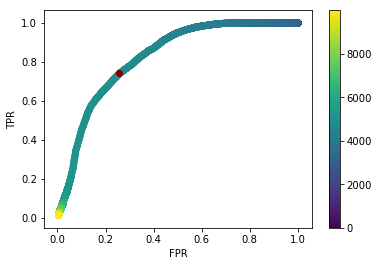

In [20]:
#Y_pred = -Y_pred
thr_min = -5
thr_max = 5
test_accuracy = 0.001
test_range = int((thr_max - thr_min)/test_accuracy)
print(test_range)
FP = []
TP = []
TN = []
FN = []
TA = np.ones((Y_pred.shape[0],))
TA[Class[lower_lim:upper_lim] ==0 ] = 0
TA[Class[lower_lim:upper_lim] ==2 ] = 0

for i in range(test_range):
    FP_temp = np.zeros((Y_pred.shape[0]))
    TP_temp = np.zeros((Y_pred.shape[0]))
    TN_temp = np.zeros((Y_pred.shape[0]))
    FN_temp = np.zeros((Y_pred.shape[0]))
    LA = np.zeros((Y_pred.shape[0],))
    thr_now = thr_min+ i*test_accuracy
    LA[Y_pred[:,0] > thr_now] = 1
    for j in range(Y_pred.shape[0]):
        if LA[j]==0:
            if TA[j]==1:
                FN_temp[j] = 1
            else:
                TN_temp[j] = 1
        else:
            if TA[j] == 1:
                TP_temp[j] = 1
            else:
                FP_temp[j] = 1
    FP.append(FP_temp)
    TP.append(TP_temp)
    TN.append(TN_temp)
    FN.append(FN_temp)
    
TPR = np.zeros((test_range,))
FPR = np.zeros((test_range,))
TPR = np.sum(TP,axis=-1)/(np.sum(TP,axis=-1)+np.sum(FN,axis=-1))
FPR = np.sum(FP,axis=-1)/(np.sum(FP,axis=-1)+np.sum(TN,axis=-1))

plt.scatter(FPR,TPR,c=[i for i in range(test_range)])

plt.colorbar()
plt.scatter(FPR[np.argmin((TPR-1)**2 + FPR**2)],TPR[np.argmin((TPR-1)**2 + FPR**2)],c=0,cmap='OrRd_r')
plt.xlabel('FPR')
plt.ylabel('TPR')
#argmax, OrRed

print("AUC:",metrics.auc(FPR, TPR))

# KL-more precise calculation

In [26]:
batch_size =100
latent_dim = 2
nb_epoch = 50  
epsilon_std = 0.1 
intermediate_dim =256
original_dim = 64*64

#USE = 'autoencoder'
USE = 'vae'
#encoder:

input_img = Input(shape=(64,64,3))


x = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(input_img)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

#x = Conv2D(5, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
#x = MaxPooling2D((2, 2),  padding='same')(x)

visual = Flatten()(x)
h_1 = Dense(intermediate_dim, activation='tanh')(visual)
encoded = Dense(latent_dim, activation='relu')(h_1)

z_mean = Dense(latent_dim)(h_1)
z_log_var = Dense(latent_dim)(h_1)

def sampling(args):   
    z_mean, z_log_var = args  
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2)* epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

if USE == 'vae':
    h_3 = Dense(intermediate_dim,activation='tanh')(z)#for VAE

if USE == 'autoencoder':
    h_3 = Dense(intermediate_dim,activation='tanh')(encoded)#for AE
    
    
h_4 = Dense(20*2*2,activation='relu')(h_3)
h_5 = Reshape((2,2,20))(h_4)


x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(h_5)
x = UpSampling2D((2, 2))(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(80,  (3, 3), activation='tanh',padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(3, (3, 3), activation='tanh', padding='same')(x)

EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')


#def vae_loss(x, decoded):
#    xent_loss = K.sum(K.sum(objectives.binary_crossentropy(x ,decoded),axis=-1),axis=-1)
#    kl_loss = - 0.5 * K.sum(1 + z_log_var - 0.5*K.square(z_mean-1) - 0.5*K.square(z_mean+1) - K.exp(z_log_var), axis=-1) 
#    return xent_loss + 1*kl_loss  
def vae_loss(x, decoded):
    xent_loss = K.sum(K.sum(objectives.binary_crossentropy(x ,decoded),axis=-1),axis=-1)
    #kl_loss_d1 = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) 
    m = K.constant(1)
    s = K.constant(1)
    #kl_loss_d1 = K.sum(K.log(2/K.exp(z_log_var/2))+(K.square(z_mean)+(K.exp(z_log_var/2)-K.constant(1))*(K.exp(z_log_var/2)+K.constant(1)))/(K.constant(2)),axis = -1)
    kl_loss_d1 = K.sum(K.log(2*s/K.exp(z_log_var/2))+(K.constant(2)*m*(-K.exp(-(K.square(z_mean))/((K.constant(2))*K.exp(z_log_var)))*K.exp(z_log_var/2) + K.sqrt(K.constant(np.pi/2))*z_mean*(K.constant(1)-K.tanh(K.constant(1.19)*z_mean/K.constant(np.sqrt(2))/K.exp(z_log_var/2)))) )/(K.square(s))+(K.square(m-z_mean)+(K.exp(z_log_var/2)-s)*(K.exp(z_log_var/2)+s))/(K.constant(2)*K.square(s)),axis = -1)
    return 1*xent_loss + 1*kl_loss_d1 




def ae_loss(x, decoded):  
    xent_loss = original_dim * objectives.mean_squared_error(x,decoded)
    return xent_loss

if USE == 'autoencoder':
    autoencoder = Model(inputs=input_img, outputs=decoded)
    autoencoder.compile(optimizer='rmsprop', loss=ae_loss)
if USE == 'vae':
    vae = Model(inputs=input_img, outputs=decoded) 
    vae.compile(optimizer='rmsprop', loss=vae_loss) 

In [27]:
vae.fit(train_data[:12000], train_data[:12000],
        shuffle=True,
        epochs=50,
        batch_size=batch_size,
        validation_data=(train_data[12000:14100],train_data[12000:14100]),callbacks=[EarlyStopping])

Train on 12000 samples, validate on 2100 samples
Epoch 1/50
12000/12000 [==============================] - 19s - loss: -7423.8971 - val_loss: -7895.2592
Epoch 2/50
12000/12000 [==============================] - 18s - loss: -7939.5623 - val_loss: -7939.2995
Epoch 3/50
12000/12000 [==============================] - 18s - loss: -7987.4812 - val_loss: -7958.9724
Epoch 4/50
12000/12000 [==============================] - 18s - loss: -8013.0846 - val_loss: -8004.5246
Epoch 5/50
12000/12000 [==============================] - 18s - loss: -8020.8921 - val_loss: -8017.4138
Epoch 6/50
12000/12000 [==============================] - 18s - loss: -8014.0615 - val_loss: -8017.8524
Epoch 7/50
12000/12000 [==============================] - 18s - loss: -8018.3241 - val_loss: -7930.7094
Epoch 8/50
12000/12000 [==============================] - 18s - loss: -8036.6379 - val_loss: -8025.0567
Epoch 9/50
12000/12000 [==============================] - 18s - loss: -8053.4228 - val_loss: -7875.4163
Epoch 10/50
120

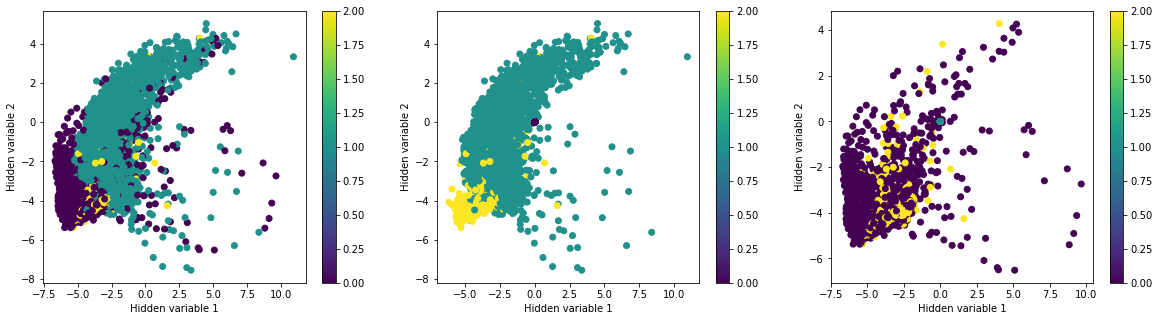

In [28]:
lower_lim = 0
upper_lim = 14100

label_value = np.zeros(len(train_label))
for i in range(len(label_value)):
    label_value[i] =np.argmax(train_label[i])

vis = Model(input_img, z_mean)

# display a 2D plot of the digit classes in the latent space  
x_vis = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)

x_vis_1 = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)  
x_vis_1[label_value[lower_lim:upper_lim]<1]=0

x_vis_2 = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)  
x_vis_2[label_value[lower_lim:upper_lim]==1]=0

plt.figure(figsize=(20, 5))

ax = plt.subplot(1,3,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,3,2)
plt.scatter( x_vis_1[:, 0] ,x_vis_1[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,3,3)
plt.scatter( x_vis_2[:, 0] ,x_vis_2[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()

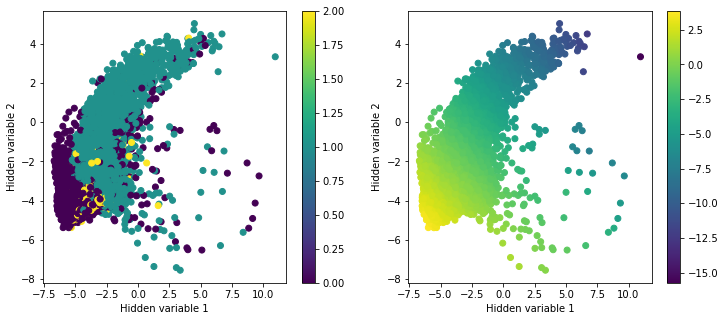

In [29]:
lower_lim = 0
upper_lim = 14100


vis = Model(input_img, z_mean)
# display a 2D plot of the digit classes in the latent space
x_vis = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)
n_neighbors = 10
n_components = 1
isomap = manifold.Isomap(n_neighbors, n_components)
hid_pred = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)
Y_pred = isomap.fit_transform(hid_pred)


plt.figure(figsize=(12, 5))

ax = plt.subplot(1,2,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,2,2)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=Y_pred)
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()

10000
AUC: 0.910302118254


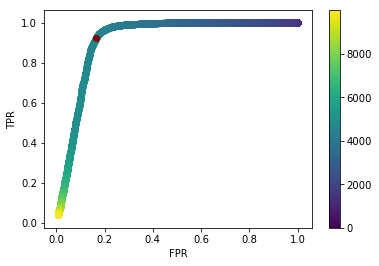

In [30]:
Y_pred = -Y_pred
thr_min = -5
thr_max = 5
test_accuracy = 0.001
test_range = int((thr_max - thr_min)/test_accuracy)
print(test_range)
FP = []
TP = []
TN = []
FN = []
TA = np.ones((Y_pred.shape[0],))
TA[Class[lower_lim:upper_lim] ==0 ] = 0
TA[Class[lower_lim:upper_lim] ==2 ] = 0

for i in range(test_range):
    FP_temp = np.zeros((Y_pred.shape[0]))
    TP_temp = np.zeros((Y_pred.shape[0]))
    TN_temp = np.zeros((Y_pred.shape[0]))
    FN_temp = np.zeros((Y_pred.shape[0]))
    LA = np.zeros((Y_pred.shape[0],))
    thr_now = thr_min+ i*test_accuracy
    LA[Y_pred[:,0] > thr_now] = 1
    for j in range(Y_pred.shape[0]):
        if LA[j]==0:
            if TA[j]==1:
                FN_temp[j] = 1
            else:
                TN_temp[j] = 1
        else:
            if TA[j] == 1:
                TP_temp[j] = 1
            else:
                FP_temp[j] = 1
    FP.append(FP_temp)
    TP.append(TP_temp)
    TN.append(TN_temp)
    FN.append(FN_temp)
    
TPR = np.zeros((test_range,))
FPR = np.zeros((test_range,))
TPR = np.sum(TP,axis=-1)/(np.sum(TP,axis=-1)+np.sum(FN,axis=-1))
FPR = np.sum(FP,axis=-1)/(np.sum(FP,axis=-1)+np.sum(TN,axis=-1))

plt.scatter(FPR,TPR,c=[i for i in range(test_range)])

plt.colorbar()
plt.scatter(FPR[np.argmin((TPR-1)**2 + FPR**2)],TPR[np.argmin((TPR-1)**2 + FPR**2)],c=0,cmap='OrRd_r')
plt.xlabel('FPR')
plt.ylabel('TPR')
#argmax, OrRed

print("AUC:",metrics.auc(FPR, TPR))

# AW loss

In [31]:
batch_size =100
latent_dim = 2
nb_epoch = 50  
epsilon_std = 0.1  
intermediate_dim =256
original_dim = 64*64

#USE = 'autoencoder'
USE = 'vae'
#encoder:

input_img = Input(shape=(64,64,3))


x = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(input_img)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

#x = Conv2D(5, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
#x = MaxPooling2D((2, 2),  padding='same')(x)

visual = Flatten()(x)
h_1 = Dense(intermediate_dim, activation='tanh')(visual)
encoded = Dense(latent_dim, activation='relu')(h_1)

#z_mean = Dense(latent_dim)(h_1)
z_mean = Dense(latent_dim,activation='tanh')(h_1)
z_log_var = Dense(latent_dim)(h_1)

def sampling(args):   
    z_mean, z_log_var = args  
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2)* epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

if USE == 'vae':
    h_3 = Dense(intermediate_dim,activation='tanh')(z)#for VAE

if USE == 'autoencoder':
    h_3 = Dense(intermediate_dim,activation='tanh')(encoded)#for AE
    
    
h_4 = Dense(20*2*2,activation='relu')(h_3)
h_5 = Reshape((2,2,20))(h_4)


x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(h_5)
x = UpSampling2D((2, 2))(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(80,  (3, 3), activation='tanh',padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(3, (3, 3), activation='tanh', padding='same')(x)

EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')


def vae_loss(x, decoded):  
    xent_loss = K.sum(K.sum(objectives.binary_crossentropy(x ,decoded),axis=-1),axis=-1)
    kl_loss_1 = -K.sum(K.square(0 - (z_mean)), axis=-1)
    kl_loss_2 = K.sum(K.abs(1- K.exp(z_log_var)), axis=-1)
    return 1*xent_loss + 0.5*kl_loss_1 + 1*kl_loss_2  

def ae_loss(x, decoded):  
    xent_loss = original_dim * objectives.mean_squared_error(x,decoded)
    return xent_loss

if USE == 'autoencoder':
    autoencoder = Model(inputs=input_img, outputs=decoded)
    autoencoder.compile(optimizer='rmsprop', loss=ae_loss)
if USE == 'vae':
    vae = Model(inputs=input_img, outputs=decoded) 
    vae.compile(optimizer='rmsprop', loss=vae_loss) 

In [32]:
vae.fit(train_data[:12000], train_data[:12000],
        shuffle=True,
        epochs=50,
        batch_size=batch_size,
        validation_data=(train_data[12000:14100],train_data[12000:14100]),callbacks=[EarlyStopping])

Train on 12000 samples, validate on 2100 samples
Epoch 1/50
12000/12000 [==============================] - 19s - loss: -7377.6524 - val_loss: -7650.7301
Epoch 2/50
12000/12000 [==============================] - 18s - loss: -7831.7370 - val_loss: -7872.8200
Epoch 3/50
12000/12000 [==============================] - 18s - loss: -7924.1529 - val_loss: -7938.9118
Epoch 4/50
12000/12000 [==============================] - 18s - loss: -7921.3425 - val_loss: -8002.7116
Epoch 5/50
12000/12000 [==============================] - 18s - loss: -7992.2305 - val_loss: -7996.0940
Epoch 6/50
12000/12000 [==============================] - 18s - loss: -8000.9904 - val_loss: -7991.5473
Epoch 7/50
12000/12000 [==============================] - 18s - loss: -8011.4835 - val_loss: -7780.1578
Epoch 8/50
12000/12000 [==============================] - 18s - loss: -8026.9778 - val_loss: -7976.6845
Epoch 9/50
12000/12000 [==============================] - 18s - loss: -8024.6652 - val_loss: -8018.0659
Epoch 10/50
120

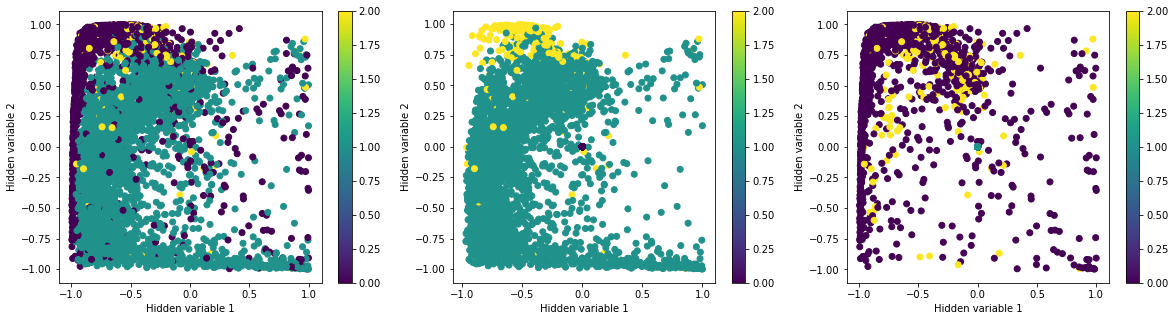

In [33]:
lower_lim = 0
upper_lim = 14100

label_value = np.zeros(len(train_label))
for i in range(len(label_value)):
    label_value[i] =np.argmax(train_label[i])

vis = Model(input_img, z_mean)

# display a 2D plot of the digit classes in the latent space  
x_vis = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)

x_vis_1 = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)  
x_vis_1[label_value[lower_lim:upper_lim]<1]=0

x_vis_2 = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)  
x_vis_2[label_value[lower_lim:upper_lim]==1]=0

plt.figure(figsize=(20, 5))

ax = plt.subplot(1,3,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,3,2)
plt.scatter( x_vis_1[:, 0] ,x_vis_1[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,3,3)
plt.scatter( x_vis_2[:, 0] ,x_vis_2[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()

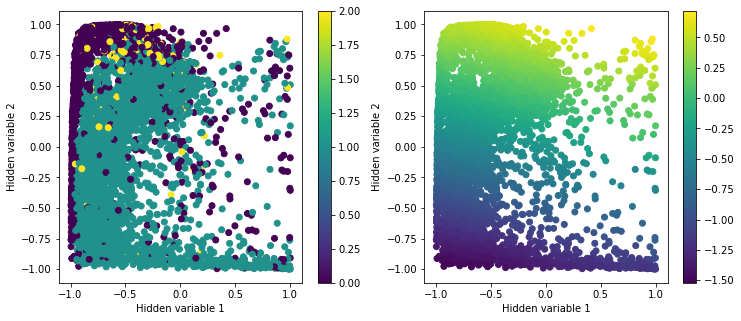

In [34]:
lower_lim = 0
upper_lim = 14100


vis = Model(input_img, z_mean)
# display a 2D plot of the digit classes in the latent space
x_vis = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)
n_neighbors = 10
n_components = 1
isomap = manifold.Isomap(n_neighbors, n_components)
hid_pred = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)
Y_pred = isomap.fit_transform(hid_pred)


plt.figure(figsize=(12, 5))

ax = plt.subplot(1,2,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,2,2)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=Y_pred)
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()

10000
AUC: 0.873542696373


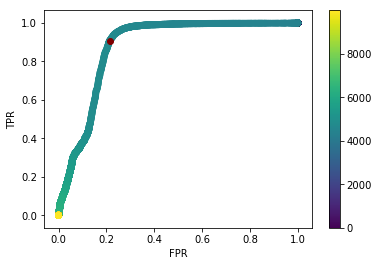

In [35]:
Y_pred = -Y_pred
thr_min = -5
thr_max = 5
test_accuracy = 0.001
test_range = int((thr_max - thr_min)/test_accuracy)
print(test_range)
FP = []
TP = []
TN = []
FN = []
TA = np.ones((Y_pred.shape[0],))
TA[Class[lower_lim:upper_lim] ==0 ] = 0
TA[Class[lower_lim:upper_lim] ==2 ] = 0

for i in range(test_range):
    FP_temp = np.zeros((Y_pred.shape[0]))
    TP_temp = np.zeros((Y_pred.shape[0]))
    TN_temp = np.zeros((Y_pred.shape[0]))
    FN_temp = np.zeros((Y_pred.shape[0]))
    LA = np.zeros((Y_pred.shape[0],))
    thr_now = thr_min+ i*test_accuracy
    LA[Y_pred[:,0] > thr_now] = 1
    for j in range(Y_pred.shape[0]):
        if LA[j]==0:
            if TA[j]==1:
                FN_temp[j] = 1
            else:
                TN_temp[j] = 1
        else:
            if TA[j] == 1:
                TP_temp[j] = 1
            else:
                FP_temp[j] = 1
    FP.append(FP_temp)
    TP.append(TP_temp)
    TN.append(TN_temp)
    FN.append(FN_temp)
    
TPR = np.zeros((test_range,))
FPR = np.zeros((test_range,))
TPR = np.sum(TP,axis=-1)/(np.sum(TP,axis=-1)+np.sum(FN,axis=-1))
FPR = np.sum(FP,axis=-1)/(np.sum(FP,axis=-1)+np.sum(TN,axis=-1))

plt.scatter(FPR,TPR,c=[i for i in range(test_range)])

plt.colorbar()
plt.scatter(FPR[np.argmin((TPR-1)**2 + FPR**2)],TPR[np.argmin((TPR-1)**2 + FPR**2)],c=0,cmap='OrRd_r')
plt.xlabel('FPR')
plt.ylabel('TPR')
#argmax, OrRed

print("AUC:",metrics.auc(FPR, TPR))

# Sigle Gaussian PW loss: Check the code by dealing with a familiar situation

In [36]:
batch_size =100
latent_dim = 2
nb_epoch = 50  
epsilon_std = 0.1  
intermediate_dim =256
original_dim = 64*64

#USE = 'autoencoder'
USE = 'vae'
#encoder:

input_img = Input(shape=(64,64,3))


x = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(input_img)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

#x = Conv2D(5, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
#x = MaxPooling2D((2, 2),  padding='same')(x)

visual = Flatten()(x)
h_1 = Dense(intermediate_dim, activation='tanh')(visual)
encoded = Dense(latent_dim, activation='relu')(h_1)

#z_mean = Dense(latent_dim)(h_1)
z_mean = Dense(latent_dim)(h_1)
z_log_var = Dense(latent_dim)(h_1)

def sampling(args):   
    z_mean, z_log_var = args  
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2)* epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

if USE == 'vae':
    h_3 = Dense(intermediate_dim,activation='tanh')(z)#for VAE

if USE == 'autoencoder':
    h_3 = Dense(intermediate_dim,activation='tanh')(encoded)#for AE
    
    
h_4 = Dense(20*2*2,activation='relu')(h_3)
h_5 = Reshape((2,2,20))(h_4)


x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(h_5)
x = UpSampling2D((2, 2))(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(80,  (3, 3), activation='tanh',padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(3, (3, 3), activation='tanh', padding='same')(x)

EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')


#def vae_loss(x, decoded):  
#    xent_loss = K.sum(K.sum(objectives.binary_crossentropy(x ,decoded),axis=-1),axis=-1)
#    kl_loss_1 = -K.sum(K.square(0 - (z_mean)), axis=-1)
#    kl_loss_2 = K.sum(K.abs(1- K.exp(z_log_var)), axis=-1)
#    return 1*xent_loss + 0.5*kl_loss_1 + 1*kl_loss_2  
### PW loss:
def vae_loss(x, decoded):  
    xent_loss = K.sum(K.sum(objectives.binary_crossentropy(x ,decoded),axis=-1),axis=-1)#the cross entropy loss, can also use MSE
    w_loss_d1_mean = K.sum(K.square((z_mean)), axis=-1) #first part of PW loss
    m = K.constant(0) #hyperparameter: mean
    s = K.constant(1) #hyperparameter: std
    w_loss_d1_var = K.sum((        
        K.exp(-K.square(m/s)-K.square(z_mean)/K.constant(2)/(K.square(s)+K.exp(z_log_var)))*
            (
            -K.constant(2*np.sqrt(2))*K.exp((m*(-K.constant(2)*z_mean*K.square(s)+m*(K.square(s)+K.constant(2)*K.exp(z_log_var))))/(K.constant(2)*K.square(s)*(K.square(s)+K.exp(z_log_var))))
            -K.constant(2*np.sqrt(2))*K.exp((m*(K.constant(2)*z_mean*K.square(s)+m*(K.square(s)+K.constant(2)*K.exp(z_log_var))))/(K.constant(2)*K.square(s)*(K.square(s)+K.exp(z_log_var))))
            +K.exp(z_log_var/2)*K.exp((K.square(z_mean))/(K.constant(2)*(K.square(s)+K.exp(z_log_var))))*K.sqrt(K.constant(1)/K.square(s)+K.constant(1)/K.exp(z_log_var))
            +K.exp(K.square(m/s)+(K.square(z_mean))/(K.constant(2)*(K.square(s)+K.exp(z_log_var))))*K.exp(z_log_var/2)*s*(K.constant(1)/s+K.constant(2)/K.exp(z_log_var/2))*K.sqrt(K.constant(1)/K.square(s)+K.constant(1)/K.exp(z_log_var))
            )
        )
        /(K.constant(4)*K.constant(np.sqrt(np.pi))*s*K.exp(z_log_var/2)*K.sqrt(K.constant(1)/K.square(s)+K.constant(1)/K.exp(z_log_var))), axis=-1)
    #second part of PW loss
    return 1*xent_loss +w_loss_d1_mean+w_loss_d1_var 
    

def ae_loss(x, decoded):  
    xent_loss = original_dim * objectives.mean_squared_error(x,decoded)
    return xent_loss

if USE == 'autoencoder':
    autoencoder = Model(inputs=input_img, outputs=decoded)
    autoencoder.compile(optimizer='rmsprop', loss=ae_loss)
if USE == 'vae':
    vae = Model(inputs=input_img, outputs=decoded) 
    vae.compile(optimizer='rmsprop', loss=vae_loss) 

In [37]:
vae.fit(train_data[:12000], train_data[:12000],
        shuffle=True,
        epochs=50,
        batch_size=batch_size,
        validation_data=(train_data[12000:14100],train_data[12000:14100]),callbacks=[EarlyStopping])

Train on 12000 samples, validate on 2100 samples
Epoch 1/50
12000/12000 [==============================] - 20s - loss: -7282.9298 - val_loss: -7681.1622
Epoch 2/50
12000/12000 [==============================] - 18s - loss: -7855.5773 - val_loss: -7897.9952
Epoch 3/50
12000/12000 [==============================] - 18s - loss: -7940.6613 - val_loss: -7997.2955
Epoch 4/50
12000/12000 [==============================] - 18s - loss: -7986.4377 - val_loss: -7950.5938
Epoch 5/50
12000/12000 [==============================] - 18s - loss: -8001.2392 - val_loss: -7849.6723
Epoch 6/50
12000/12000 [==============================] - 18s - loss: -7987.7972 - val_loss: -7944.8508
Epoch 7/50
12000/12000 [==============================] - 18s - loss: -8025.7584 - val_loss: -7989.9922
Epoch 8/50
12000/12000 [==============================] - 18s - loss: -8022.0206 - val_loss: -8002.2287
Epoch 9/50
12000/12000 [==============================] - 18s - loss: -8037.1028 - val_loss: -7816.9892
Epoch 10/50
120

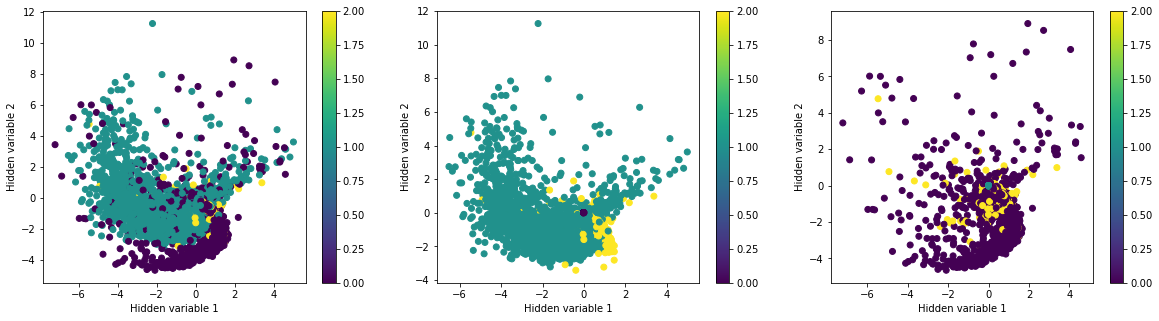

In [38]:
lower_lim = 0
upper_lim = 14100

label_value = np.zeros(len(train_label))
for i in range(len(label_value)):
    label_value[i] =np.argmax(train_label[i])

vis = Model(input_img, z_mean)

# display a 2D plot of the digit classes in the latent space  
x_vis = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)

x_vis_1 = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)  
x_vis_1[label_value[lower_lim:upper_lim]<1]=0

x_vis_2 = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)  
x_vis_2[label_value[lower_lim:upper_lim]==1]=0

plt.figure(figsize=(20, 5))

ax = plt.subplot(1,3,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,3,2)
plt.scatter( x_vis_1[:, 0] ,x_vis_1[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,3,3)
plt.scatter( x_vis_2[:, 0] ,x_vis_2[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()

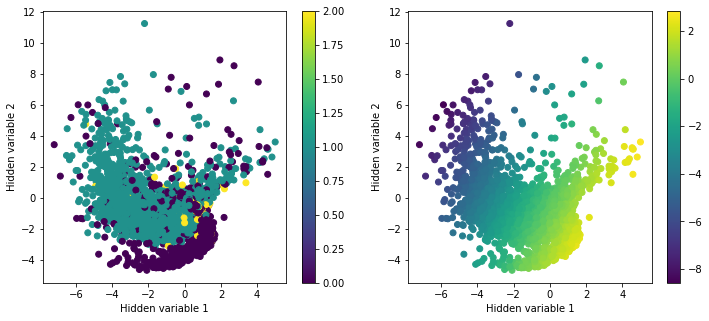

In [39]:
lower_lim = 0
upper_lim = 14100


vis = Model(input_img, z_mean)
# display a 2D plot of the digit classes in the latent space
x_vis = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)
n_neighbors = 10
n_components = 1
isomap = manifold.Isomap(n_neighbors, n_components)
hid_pred = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)
Y_pred = isomap.fit_transform(hid_pred)


plt.figure(figsize=(12, 5))

ax = plt.subplot(1,2,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,2,2)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=Y_pred)
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()

10000
AUC: 0.851868511992


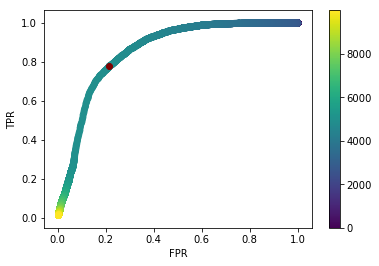

In [40]:
Y_pred = -Y_pred
thr_min = -5
thr_max = 5
test_accuracy = 0.001
test_range = int((thr_max - thr_min)/test_accuracy)
print(test_range)
FP = []
TP = []
TN = []
FN = []
TA = np.ones((Y_pred.shape[0],))
TA[Class[lower_lim:upper_lim] ==0 ] = 0
TA[Class[lower_lim:upper_lim] ==2 ] = 0

for i in range(test_range):
    FP_temp = np.zeros((Y_pred.shape[0]))
    TP_temp = np.zeros((Y_pred.shape[0]))
    TN_temp = np.zeros((Y_pred.shape[0]))
    FN_temp = np.zeros((Y_pred.shape[0]))
    LA = np.zeros((Y_pred.shape[0],))
    thr_now = thr_min+ i*test_accuracy
    LA[Y_pred[:,0] > thr_now] = 1
    for j in range(Y_pred.shape[0]):
        if LA[j]==0:
            if TA[j]==1:
                FN_temp[j] = 1
            else:
                TN_temp[j] = 1
        else:
            if TA[j] == 1:
                TP_temp[j] = 1
            else:
                FP_temp[j] = 1
    FP.append(FP_temp)
    TP.append(TP_temp)
    TN.append(TN_temp)
    FN.append(FN_temp)
    
TPR = np.zeros((test_range,))
FPR = np.zeros((test_range,))
TPR = np.sum(TP,axis=-1)/(np.sum(TP,axis=-1)+np.sum(FN,axis=-1))
FPR = np.sum(FP,axis=-1)/(np.sum(FP,axis=-1)+np.sum(TN,axis=-1))

plt.scatter(FPR,TPR,c=[i for i in range(test_range)])

plt.colorbar()
plt.scatter(FPR[np.argmin((TPR-1)**2 + FPR**2)],TPR[np.argmin((TPR-1)**2 + FPR**2)],c=0,cmap='OrRd_r')
plt.xlabel('FPR')
plt.ylabel('TPR')
#argmax, OrRed

print("AUC:",metrics.auc(FPR, TPR))

## such result shows it's a quite regular result like when we use single peak KL loss

# PW loss

In [41]:
batch_size =100
latent_dim = 2
nb_epoch = 50  
epsilon_std = 0.1  
intermediate_dim =256
original_dim = 64*64

#USE = 'autoencoder'
USE = 'vae'
#encoder:

input_img = Input(shape=(64,64,3))


x = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(input_img)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

#x = Conv2D(5, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
#x = MaxPooling2D((2, 2),  padding='same')(x)

visual = Flatten()(x)
h_1 = Dense(intermediate_dim, activation='tanh')(visual)
encoded = Dense(latent_dim, activation='relu')(h_1)

#z_mean = Dense(latent_dim)(h_1)
z_mean = Dense(latent_dim)(h_1)
z_log_var = Dense(latent_dim)(h_1)

def sampling(args):   
    z_mean, z_log_var = args  
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2)* epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

if USE == 'vae':
    h_3 = Dense(intermediate_dim,activation='tanh')(z)#for VAE

if USE == 'autoencoder':
    h_3 = Dense(intermediate_dim,activation='tanh')(encoded)#for AE
    
    
h_4 = Dense(20*2*2,activation='relu')(h_3)
h_5 = Reshape((2,2,20))(h_4)


x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(h_5)
x = UpSampling2D((2, 2))(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(80,  (3, 3), activation='tanh',padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(3, (3, 3), activation='tanh', padding='same')(x)

EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')


#def vae_loss(x, decoded):  
#    xent_loss = K.sum(K.sum(objectives.binary_crossentropy(x ,decoded),axis=-1),axis=-1)
#    kl_loss_1 = -K.sum(K.square(0 - (z_mean)), axis=-1)
#    kl_loss_2 = K.sum(K.abs(1- K.exp(z_log_var)), axis=-1)
#    return 1*xent_loss + 0.5*kl_loss_1 + 1*kl_loss_2  
### PW loss:
def vae_loss(x, decoded):  
    xent_loss = K.sum(K.sum(objectives.binary_crossentropy(x ,decoded),axis=-1),axis=-1)#the cross entropy loss, can also use MSE
    w_loss_d1_mean = K.sum(K.square((z_mean)), axis=-1) #first part of PW loss
    m = K.constant(1) #hyperparameter: mean
    s = K.constant(1) #hyperparameter: std
    w_loss_d1_var = K.sum((        
        K.exp(-K.square(m/s)-K.square(z_mean)/K.constant(2)/(K.square(s)+K.exp(z_log_var)))*
            (
            -K.constant(2*np.sqrt(2))*K.exp((m*(-K.constant(2)*z_mean*K.square(s)+m*(K.square(s)+K.constant(2)*K.exp(z_log_var))))/(K.constant(2)*K.square(s)*(K.square(s)+K.exp(z_log_var))))
            -K.constant(2*np.sqrt(2))*K.exp((m*(K.constant(2)*z_mean*K.square(s)+m*(K.square(s)+K.constant(2)*K.exp(z_log_var))))/(K.constant(2)*K.square(s)*(K.square(s)+K.exp(z_log_var))))
            +K.exp(z_log_var/2)*K.exp((K.square(z_mean))/(K.constant(2)*(K.square(s)+K.exp(z_log_var))))*K.sqrt(K.constant(1)/K.square(s)+K.constant(1)/K.exp(z_log_var))
            +K.exp(K.square(m/s)+(K.square(z_mean))/(K.constant(2)*(K.square(s)+K.exp(z_log_var))))*K.exp(z_log_var/2)*s*(K.constant(1)/s+K.constant(2)/K.exp(z_log_var/2))*K.sqrt(K.constant(1)/K.square(s)+K.constant(1)/K.exp(z_log_var))
            )
        )
        /(K.constant(4)*K.constant(np.sqrt(np.pi))*s*K.exp(z_log_var/2)*K.sqrt(K.constant(1)/K.square(s)+K.constant(1)/K.exp(z_log_var))), axis=-1)
    #second part of PW loss
    return 1*xent_loss +w_loss_d1_mean+w_loss_d1_var 
    

def ae_loss(x, decoded):  
    xent_loss = original_dim * objectives.mean_squared_error(x,decoded)
    return xent_loss

if USE == 'autoencoder':
    autoencoder = Model(inputs=input_img, outputs=decoded)
    autoencoder.compile(optimizer='rmsprop', loss=ae_loss)
if USE == 'vae':
    vae = Model(inputs=input_img, outputs=decoded) 
    vae.compile(optimizer='rmsprop', loss=vae_loss) 

In [42]:
vae.fit(train_data[:12000], train_data[:12000],
        shuffle=True,
        epochs=50,
        batch_size=batch_size,
        validation_data=(train_data[12000:14100],train_data[12000:14100]),callbacks=[EarlyStopping])

Train on 12000 samples, validate on 2100 samples
Epoch 1/50
12000/12000 [==============================] - 20s - loss: -7304.6464 - val_loss: -7081.2660
Epoch 2/50
12000/12000 [==============================] - 18s - loss: -7849.3505 - val_loss: -7863.4352
Epoch 3/50
12000/12000 [==============================] - 18s - loss: -7947.3098 - val_loss: -7726.8745
Epoch 4/50
12000/12000 [==============================] - 18s - loss: -7949.2431 - val_loss: -7982.2788
Epoch 5/50
12000/12000 [==============================] - 18s - loss: -8010.0394 - val_loss: -8020.0052
Epoch 6/50
12000/12000 [==============================] - 18s - loss: -8023.3539 - val_loss: -8026.5508
Epoch 7/50
12000/12000 [==============================] - 18s - loss: -8035.5729 - val_loss: -7929.0654
Epoch 8/50
12000/12000 [==============================] - 18s - loss: -8032.1008 - val_loss: -8035.6200
Epoch 9/50
12000/12000 [==============================] - 18s - loss: -8037.3348 - val_loss: -8017.7360
Epoch 10/50
120

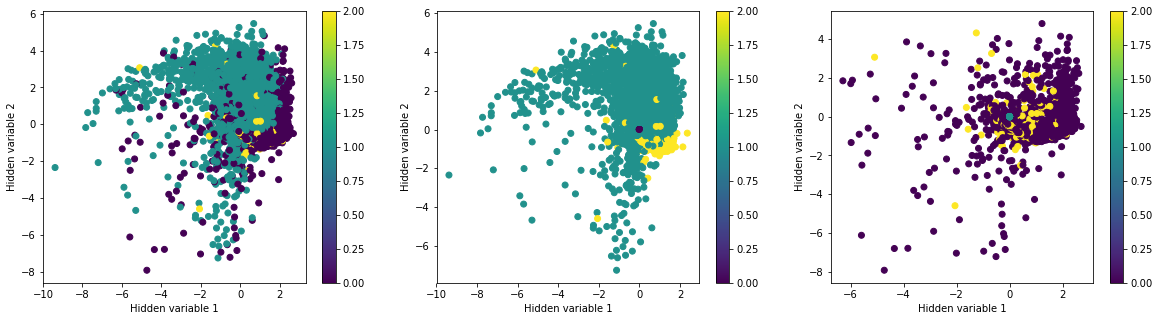

In [43]:
lower_lim = 0
upper_lim = 14100

label_value = np.zeros(len(train_label))
for i in range(len(label_value)):
    label_value[i] =np.argmax(train_label[i])

vis = Model(input_img, z_mean)

# display a 2D plot of the digit classes in the latent space  
x_vis = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)

x_vis_1 = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)  
x_vis_1[label_value[lower_lim:upper_lim]<1]=0

x_vis_2 = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)  
x_vis_2[label_value[lower_lim:upper_lim]==1]=0

plt.figure(figsize=(20, 5))

ax = plt.subplot(1,3,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,3,2)
plt.scatter( x_vis_1[:, 0] ,x_vis_1[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,3,3)
plt.scatter( x_vis_2[:, 0] ,x_vis_2[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()

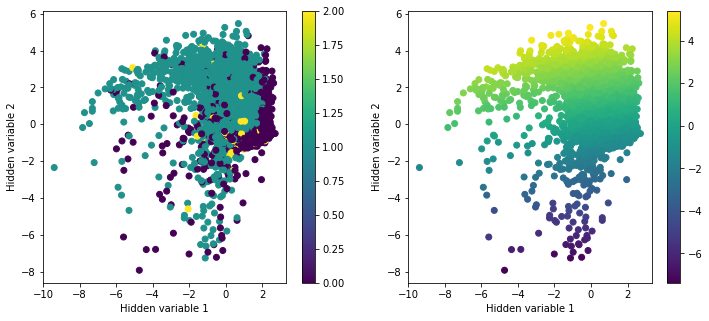

In [44]:
lower_lim = 0
upper_lim = 14100


vis = Model(input_img, z_mean)
# display a 2D plot of the digit classes in the latent space
x_vis = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)
n_neighbors = 10
n_components = 1
isomap = manifold.Isomap(n_neighbors, n_components)
hid_pred = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)
Y_pred = isomap.fit_transform(hid_pred)


plt.figure(figsize=(12, 5))

ax = plt.subplot(1,2,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,2,2)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=Y_pred)
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()

10000
AUC: 0.87542682667


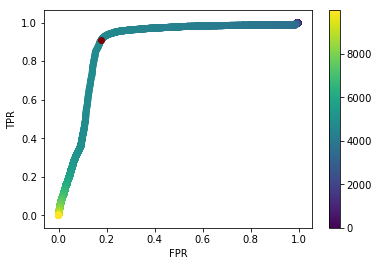

In [45]:
#Y_pred = -Y_pred
thr_min = -5
thr_max = 5
test_accuracy = 0.001
test_range = int((thr_max - thr_min)/test_accuracy)
print(test_range)
FP = []
TP = []
TN = []
FN = []
TA = np.ones((Y_pred.shape[0],))
TA[Class[lower_lim:upper_lim] ==0 ] = 0
TA[Class[lower_lim:upper_lim] ==2 ] = 0

for i in range(test_range):
    FP_temp = np.zeros((Y_pred.shape[0]))
    TP_temp = np.zeros((Y_pred.shape[0]))
    TN_temp = np.zeros((Y_pred.shape[0]))
    FN_temp = np.zeros((Y_pred.shape[0]))
    LA = np.zeros((Y_pred.shape[0],))
    thr_now = thr_min+ i*test_accuracy
    LA[Y_pred[:,0] > thr_now] = 1
    for j in range(Y_pred.shape[0]):
        if LA[j]==0:
            if TA[j]==1:
                FN_temp[j] = 1
            else:
                TN_temp[j] = 1
        else:
            if TA[j] == 1:
                TP_temp[j] = 1
            else:
                FP_temp[j] = 1
    FP.append(FP_temp)
    TP.append(TP_temp)
    TN.append(TN_temp)
    FN.append(FN_temp)
    
TPR = np.zeros((test_range,))
FPR = np.zeros((test_range,))
TPR = np.sum(TP,axis=-1)/(np.sum(TP,axis=-1)+np.sum(FN,axis=-1))
FPR = np.sum(FP,axis=-1)/(np.sum(FP,axis=-1)+np.sum(TN,axis=-1))

plt.scatter(FPR,TPR,c=[i for i in range(test_range)])

plt.colorbar()
plt.scatter(FPR[np.argmin((TPR-1)**2 + FPR**2)],TPR[np.argmin((TPR-1)**2 + FPR**2)],c=0,cmap='OrRd_r')
plt.xlabel('FPR')
plt.ylabel('TPR')
#argmax, OrRed

print("AUC:",metrics.auc(FPR, TPR))